# Intent Detection - Enron - Binary Text Classification


In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

In [2]:
df_train=pd.read_csv("enron_train.txt",sep="\t",header=None)
df_test=pd.read_csv("enron_test.txt",sep="\t",header=None)

In [3]:
df_train.columns=["pred","content"]
df_test.columns=["pred","content"]

In [4]:
df_train['pred'].value_counts()

No     1938
Yes    1719
Name: pred, dtype: int64

In [5]:
df_test['pred'].value_counts()

No     683
Yes    309
Name: pred, dtype: int64

# Step 1 : Data Preprocessing - Expanding contractions & data cleaning

In [6]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = expandContractions(text)
    text = re.sub('[^a-zA-Z ]'," ",text)
    text = re.sub("'ll"," ",text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"," ",text)
    text = re.sub(r"\$\d+", " ",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', " ",text) 
    return text

In [8]:
'''REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = expandContractions(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+","$WEBLINKS",text)
    text = re.sub(r"\$\d+", "$CASH",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', "$EMAIL",text)
    text = re.sub(r'\b(me|her|him|us|them|there|that)\b', "$NOUN",text)  
    return text

'''

'REPLACE_BY_SPACE_RE = re.compile(\'[/(){}\\[\\]\\|@,?#]\')\ndef clean_text(text):\n    text = text.lower()\n    text = text.strip()\n    text = text.lstrip()   \n    text = text.rstrip()\n    text = expandContractions(text)\n    text = REPLACE_BY_SPACE_RE.sub(\' \', text)\n    text = re.sub(r"https?://(?:[-\\w.]|(?:%[\\da-fA-F]{2}))+","$WEBLINKS",text)\n    text = re.sub(r"\\$\\d+", "$CASH",text)\n    text = re.sub(r\'[\\w\\.-]+@[\\w\\.-]+\', "$EMAIL",text)\n    text = re.sub(r\'\x08(me|her|him|us|them|there|that)\x08\', "$NOUN",text)  \n    return text\n\n'

In [9]:
df_train['content'] = df_train['content'].astype(str).apply(clean_text)
df_test['content'] = df_test['content'].astype(str).apply(clean_text)

In [10]:
df_train.to_excel('train_analyze.xlsx')
df_test.to_excel('test_analyze.xlsx')

In [11]:
STOPWORDS = set(stopwords.words('english'))

In [12]:
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text) if len(word)>2 and (word not in STOPWORDS)]

# Create TF-IDF Vectors

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(min_df=0.01,stop_words=STOPWORDS)
X_train_tfidf = tfidf_vec.fit_transform(df_train['content'])

In [14]:
print(dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_)))

{'able': 5.42048219503255, 'access': 5.541110182821164, 'account': 5.33347081804292, 'add': 5.144228818404391, 'address': 4.750324532697303, 'also': 4.693812322433961, 'app': 5.567085669224425, 'attached': 5.515792374836875, 'available': 4.65079493735027, 'back': 4.785831221154213, 'best': 5.515792374836875, 'book': 5.567085669224425, 'business': 5.4670022106674425, 'call': 3.7324011552793364, 'check': 4.970565324353552, 'click': 5.0937979647775, 'com': 4.59950164296272, 'come': 5.179320138215662, 'conference': 5.354524227240752, 'contact': 5.061537102559278, 'copy': 5.4434717132572485, 'could': 4.27019789582012, 'day': 4.900606735746641, 'days': 5.515792374836875, 'deal': 5.42048219503255, 'dinner': 5.376030432461716, 'discuss': 3.8386958139289598, 'email': 3.962924813891169, 'enron': 5.015017086924385, 'feel': 5.567085669224425, 'find': 5.161620561116261, 'first': 5.376030432461716, 'follow': 5.541110182821164, 'following': 5.4434717132572485, 'forward': 4.36048474249222, 'free': 4.8

In [15]:
X_test_tfidf  = tfidf_vec.transform(df_test['content'])

In [16]:
print("Train Shape : ",X_train_tfidf.shape)
print("Test Shape  : ",X_test_tfidf.shape)

Train Shape :  (3657, 111)
Test Shape  :  (992, 111)


In [17]:
train_pred=df_train["pred"]
test_pred=df_test["pred"]

# Splitting Original Training Set into 80% Train & 20% Validation

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train_tfidf,train_pred,test_size=.20,random_state=40)

# Changing predictor values into numerics

In [20]:
Y_train=Y_train.map({"No":0,"Yes":1})
Y_val=Y_val.map({"No":0,"Yes":1})

# Checking Validation Accuracy with various classifiers

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

C:\Users\risha\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\risha\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [22]:
svc = SVC(kernel='rbf', gamma="scale")
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
lrc = LogisticRegression(solver='liblinear', penalty='l2',C=10.)
rfc = RandomForestClassifier(n_estimators=500, random_state=111,n_jobs=-1,max_depth=10,max_features='sqrt')
lgbm = LGBMClassifier(n_estimators=200,learning_rate=0.3,max_depth=8,max_features="sqrt")
xgb = XGBClassifier(n_estimators=150,learning_rate=0.2)

In [23]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'LR': lrc, 'RF': rfc,'LGBM':lgbm,'XGB':xgb}

## Writing some standard functions to run all classifiers easily

In [24]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [25]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, Y_train)
    pred = predict(v, X_val)
    pred_scores_word_vectors.append((k, [accuracy_score(Y_val,pred)]))

## Let's check the validation accuracy scores

In [26]:
predictions = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score'])
predictions

C:\Users\risha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score
SVC,0.706284
KN,0.598361
NB,0.707650
LR,0.724044
RF,0.722678
LGBM,0.728142
XGB,0.725410


# As we can see above, the validation accuracy for majority of the classifiers is close to 72%

In [27]:
import matplotlib.pyplot as plt
import numpy as np

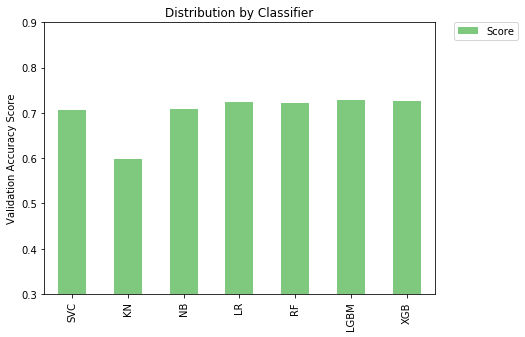

In [28]:
predictions.plot(kind='bar', ylim=(0.3,0.9), figsize=(7,5), align='center', colormap="Accent")
plt.xticks(np.arange(7), predictions.index)

plt.ylabel('Validation Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Let's test our models on the test set provided with our various classifiers

In [29]:
test_pred=test_pred.map({"No":0,"Yes":1})

In [30]:
tester = pd.DataFrame()

In [31]:
tester['LR_Model']=lrc.predict(X_test_tfidf)
tester['SVC_Model']=svc.predict(X_test_tfidf)
tester['RF_Model']=rfc.predict(X_test_tfidf)
tester['KNC_Model']=knc.predict(X_test_tfidf)
tester['NB_Model']=mnb.predict(X_test_tfidf)
tester['LGBM_Model']=lgbm.predict(X_test_tfidf)
tester['XGB_Model']=xgb.predict(X_test_tfidf)

## Logistic Regression Model

In [32]:
print('Testing accuracy: %s' % accuracy_score(tester['LR_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['LR_Model'],test_pred))

Testing accuracy: 0.7691532258064516
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       648
           1       0.69      0.62      0.65       344

   micro avg       0.77      0.77      0.77       992
   macro avg       0.75      0.73      0.74       992
weighted avg       0.76      0.77      0.77       992



## SVC Model

In [33]:
print('Testing accuracy: %s' % accuracy_score(tester['SVC_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['SVC_Model'],test_pred))

Testing accuracy: 0.7872983870967742
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       730
           1       0.58      0.69      0.63       262

   micro avg       0.79      0.79      0.79       992
   macro avg       0.73      0.76      0.74       992
weighted avg       0.80      0.79      0.79       992



## Random Forest Model

In [34]:
print('Testing accuracy: %s' % accuracy_score(tester['RF_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['RF_Model'],test_pred))

Testing accuracy: 0.7903225806451613
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       743
           1       0.57      0.70      0.63       249

   micro avg       0.79      0.79      0.79       992
   macro avg       0.73      0.76      0.74       992
weighted avg       0.81      0.79      0.80       992



## Checking Feature Importances of RFC using TF-IDF

In [35]:
print(list(zip(rfc.feature_importances_,tfidf_vec.get_feature_names(),)))

[(0.0011141416580911136, 'able'), (0.0010760165374051206, 'access'), (0.0020340826202232096, 'account'), (0.004304760143888287, 'add'), (0.0028159115398376264, 'address'), (0.0027537380845503896, 'also'), (0.0017226600144843436, 'app'), (0.0004736870143240584, 'attached'), (0.002012650651910703, 'available'), (0.002758667391397481, 'back'), (0.000550933921011666, 'best'), (0.0023894214954763297, 'book'), (0.0015742495731019806, 'business'), (0.08688040794261087, 'call'), (0.002405506458533947, 'check'), (0.0043079208466673576, 'click'), (0.0029373106805670743, 'com'), (0.004183103685504146, 'come'), (0.0020915951453901876, 'conference'), (0.003691530363516496, 'contact'), (0.0056464763492734904, 'copy'), (0.023547563186358186, 'could'), (0.0032440399355784214, 'day'), (0.0010788934815688879, 'days'), (0.0007508779665398203, 'deal'), (0.0013152425193534746, 'dinner'), (0.11509886253008532, 'discuss'), (0.006756419557168841, 'email'), (0.002388628736148121, 'enron'), (0.00155308769922874

## K-Neighbours Classifier

In [36]:
print('Testing accuracy: %s' % accuracy_score(tester['KNC_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['KNC_Model'],test_pred))

Testing accuracy: 0.7298387096774194
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       863
           1       0.28      0.66      0.39       129

   micro avg       0.73      0.73      0.73       992
   macro avg       0.61      0.70      0.61       992
weighted avg       0.85      0.73      0.77       992



## Multinomial Naive Bayes Model

In [37]:
print('Testing accuracy: %s' % accuracy_score(tester['NB_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['NB_Model'],test_pred))

Testing accuracy: 0.7399193548387096
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       647
           1       0.64      0.57      0.61       345

   micro avg       0.74      0.74      0.74       992
   macro avg       0.71      0.70      0.71       992
weighted avg       0.73      0.74      0.74       992



## LGBM Classifier

In [38]:
print('Testing accuracy: %s' % accuracy_score(tester['LGBM_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['LGBM_Model'],test_pred))

Testing accuracy: 0.7338709677419355
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       617
           1       0.68      0.56      0.61       375

   micro avg       0.73      0.73      0.73       992
   macro avg       0.72      0.70      0.71       992
weighted avg       0.73      0.73      0.73       992



# XGBoost Model

In [39]:
print('Testing accuracy: %s' % accuracy_score(tester['XGB_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['XGB_Model'],test_pred))

Testing accuracy: 0.7560483870967742
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       641
           1       0.68      0.60      0.63       351

   micro avg       0.76      0.76      0.76       992
   macro avg       0.73      0.72      0.73       992
weighted avg       0.75      0.76      0.75       992



# Post analyzing the results, Random Forest has performed the best giving an accuracy of 77.7% on our test set. It's now time to tune these parameters using GridSearch